# Setting Up Colab and Spark

Change this section to local pyspark setting if we want to submit a .py file

In [267]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

/bin/sh: apt-get: command not found
/bin/sh: wget: command not found
tar: Error opening archive: Failed to open 'spark-2.4.5-bin-hadoop2.7.tgz'
DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support
ERROR: Could not install packages due to an EnvironmentError: [Errno 13] Permission denied: '/Library/Python/2.7/site-packages/findspark.pyc'
Consider using the `--user` option or check the permissions.



In [0]:
import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"
os.environ["PYTHONPATH"] = "/usr/local/lib/python3.6/"

In [21]:
import findspark
findspark.init()

In [22]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.config('spark.jars.packages', 'databricks:spark-deep-learning:1.3.0-spark2.4-s_2.11').master("local[*]").getOrCreate()

# Load Dataset

In [67]:
# Reading parquet dataset
transaction = spark\
            .read\
            .format('parquet')\
            .option("encoding", "UTF-8") \
            .load(r'VenmoSample.snappy.parquet')

In [5]:
transaction.show(5)

+-------+-------+----------------+-------------------+------------+-----------+--------------------+
|  user1|  user2|transaction_type|           datetime| description|is_business|            story_id|
+-------+-------+----------------+-------------------+------------+-----------+--------------------+
|1218774|1528945|         payment|2015-11-27 02:48:19|        Uber|      false|5657c473cd03c9af2...|
|5109483|4782303|         payment|2015-06-17 04:37:04|      Costco|      false|5580f9702b64f70ab...|
|4322148|3392963|         payment|2015-06-19 00:05:31|Sweaty balls|      false|55835ccb1a624b14a...|
| 469894|1333620|          charge|2016-06-03 16:34:13|          🎥|      false|5751b185cd03c9af2...|
|2960727|3442373|         payment|2016-05-29 16:23:42|           ⚡|      false|574b178ecd03c9af2...|
+-------+-------+----------------+-------------------+------------+-----------+--------------------+
only showing top 5 rows



In [7]:
# Reading csv file - word dictionary
word = spark\
            .read\
            .option('header','true')\
            .option('inferSchema','true')\
            .csv(r'Venmo Word Classification Dictonary BAX-243 - Word_Dict.csv')

In [9]:
word.show(5)

+----------+---------+---------+--------+-------+---------------+-----------+-----+----------------+
|   People |    Food |   Event |Activity|Travel |Transportation |   Utility | Cash|Illegal/Sarcasm |
+----------+---------+---------+--------+-------+---------------+-----------+-----+----------------+
|    friend|     food| birthday|    ball|  beach|           lyft|       bill| atm |       addiction|
|friendship|      bbq|christmas|    boat|  place|           uber|      cable|bank |            drug|
|      baby|     bean|    happy|     bar|     la|            cab|        fee|cash |           wangs|
|       boy|    latte|     bday|    book|  world|            bus|   electric|money|            weed|
|      girl|breakfast|  wedding|    club|  hotel|            car|electricity| buck|            anal|
+----------+---------+---------+--------+-------+---------------+-----------+-----+----------------+
only showing top 5 rows



In [8]:
# Reading csv dataset
emoji_data = spark\
            .read\
            .option('header','true')\
            .option('inferSchema','true')\
            .csv(r'Venmo_Emoji_Classification_Dictionary.csv')

In [12]:
emoji_data.show(5)

+-----+------+----+--------+--------------+------+-------+
|Event|Travel|Food|Activity|Transportation|People|Utility|
+-----+------+----+--------+--------------+------+-------+
| 🇦🇺|    🏔|  🍇|      👾|            🚄|    😀|      ⚡|
| 🇫🇷|     ⛰|  🍈|      🕴|            🚅|    😃|     💡|
|   🎂|    🌋|  🍉|      🎪|            🚆|    😄|     🔌|
|   🛍|    🗻|  🍊|      🎭|            🚇|    😁|     📺|
| 🇨🇦|    🏕|  🍋|      🎨|            🚈|    😆|     🔌|
+-----+------+----+--------+--------------+------+-------+
only showing top 5 rows



# Question 1: Classify Transactions

In [9]:
! pip install emoji 

DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support


In [18]:
import sys
!{sys.executable} -m pip install emoji

In [17]:
!python -m pip uninstall pyserial --yes

DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support


In [292]:
from pyspark.ml.feature import Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark.sql.types import ArrayType, StructType, StructField, StringType, IntegerType
from pyspark.sql import Row
import emoji as em
import re
from pyspark.sql.functions import col, concat, count, sum
import pyspark.sql.functions as F
from pyspark.sql.window import Window
import math
from pyspark.sql.types import IntegerType
import matplotlib.pyplot as plt
import numpy as np

In [269]:
# Extact emojis by using emoji library to identify emojis
def extract_emojis(str):
    return ' '.join(c for c in str if c in em.UNICODE_EMOJI)
extract_emoji_udf = F.udf(lambda row:extract_emojis(row))
with_emoji = transaction.withColumn('emoji', extract_emoji_udf(F.col('description')))

# Tonkenize transaction's emoji and text description
tkn_extracted_emoji = RegexTokenizer().setInputCol('emoji').setOutputCol('emoji_list').setPattern(' ')
with_emoji = tkn_extracted_emoji.transform(with_emoji)
tkn_text = RegexTokenizer().setInputCol('description').setOutputCol('descList').setPattern(' ')
tokenized_text = tkn_text.transform(with_emoji)

In [270]:
# Combine emoji and words into one array
match_text = tokenized_text.withColumn("match_list",concat(col("emoji_list"), col("descList")))
columns_to_drop = ['emoji','descList']
df_final_words = match_text.drop(*columns_to_drop)

In [271]:
# Creat lists for text categories
people_text = [str(row['People ']) for row in word.select('People ').collect()]
food_text = [str(row['Food ']) for row in word.select('Food ').collect()]
event_text = [str(row['Event ']) for row in word.select('Event ').collect()]
activity_text = [str(row['Activity']) for row in word.select('Activity').collect()]
travel_text = [str(row['Travel ']) for row in word.select('Travel ').collect()]
tranportation_text = [str(row['Transportation ']) for row in word.select('Transportation ').collect()]
utility_text = [str(row['Utility ']) for row in word.select('Utility ').collect()]
cash_text = [str(row['Cash']) for row in word.select('Cash').collect()]
illegal_text = [str(row['Illegal/Sarcasm ']) for row in word.select('Illegal/Sarcasm ').collect()]

In [272]:
# Creat lists for emoji categories
people_emoji = [str(row['People']) for row in emoji_data.select('People').collect()]
food_emoji = [str(row['Food']) for row in emoji_data.select('Food').collect()]
event_emoji = [str(row['Event']) for row in emoji_data.select('Event').collect()]
activity_emoji = [str(row['Activity']) for row in emoji_data.select('Activity').collect()]
travel_emoji = [str(row['Travel']) for row in emoji_data.select('Travel').collect()]
tranportation_emoji = [str(row['Transportation']) for row in emoji_data.select('Transportation').collect()]
utility_emoji = [str(row['Utility']) for row in emoji_data.select('Utility').collect()]

In [273]:
# Detect words and emojis categories
check_transportation = F.udf(lambda x: 'transportation' if any(word in tranportation_text for word in x) or any(emo in tranportation_emoji for emo in x) else None)
check_people = F.udf(lambda x: 'people' if any(word in people_text for word in x) or any(emo in people_emoji for emo in x) else None)
check_food = F.udf(lambda x: 'food' if any(word in food_text for word in x) or any(emo in food_emoji for emo in x) else None)
check_event = F.udf(lambda x: 'event' if any(word in event_text for word in x) or any(emo in event_emoji for emo in x) else None)
check_activity = F.udf(lambda x: 'activity' if any(word in activity_text for word in x) or any(emo in activity_emoji for emo in x) else None)
check_travel = F.udf(lambda x: 'travel' if any(word in travel_text for word in x) or any(emo in travel_emoji for emo in x) else None)
check_utility = F.udf(lambda x: 'utility' if any(word in utility_text for word in x) or any(emo in utility_emoji for emo in x) else None)
check_cash = F.udf(lambda x: 'cash' if any(word in cash_text for word in x) else None)
check_illegal = F.udf(lambda x: 'illegal' if any(word in illegal_text for word in x) else None)

In [274]:
category_df = df_final_words.withColumn('check_transportation', check_transportation(F.col('match_list')))
category_df = category_df.withColumn('check_people', check_people(F.col('match_list')))
category_df = category_df.withColumn('check_food', check_food(F.col('match_list')))
category_df = category_df.withColumn('check_event', check_event(F.col('match_list')))
category_df = category_df.withColumn('check_activity', check_activity(F.col('match_list')))
category_df = category_df.withColumn('check_travel', check_travel(F.col('match_list')))
category_df = category_df.withColumn('check_utility', check_utility(F.col('match_list')))
category_df = category_df.withColumn('check_cash', check_cash(F.col('match_list')))
category_df = category_df.withColumn('check_illegal', check_illegal(F.col('match_list')))

In [275]:
# Assign categories to each transaction
category_df = category_df.withColumn("category",F.array(col("check_transportation"), col("check_people"),col("check_food"), col("check_event"),
        col("check_activity"), col("check_travel"),col("check_utility"), col("check_cash"),col("check_illegal")))

In [276]:
# Clean None in the category array
def eleminate_null(list_cate):
    for element in list_cate:
        if element != None:
            return element

In [277]:
eleminate_null_udf = F.udf(lambda row:[eleminate_null(row)], ArrayType(StringType()))
clean_category_df = category_df.withColumn('clean_category', eleminate_null_udf(F.col('category')))
columns_to_drop = ['check_transportation','check_people','check_food','check_event',
                  'check_activity','check_travel','check_utility','check_cash','check_illegal','category']
clean_category_df = clean_category_df.drop(*columns_to_drop)
#clean_category_df.show(5)

# Question 2: Emoji Only Transactions

In [278]:
import string  

## 2.1 What is the percent of emoji only transactions?

In [279]:
def check_emoji_only(check_list):
    if len(check_list)==0:
        return 0
    else:
        if any(x.isalpha()==True for x in check_list) or any(x.isdigit()==True for x in check_list):
            return 0
        else:
            if any(i in string.punctuation for i in check_list):
                return 0
            else:
                return 1

In [49]:
filter_emoji_only = F.udf(lambda row:check_emoji_only(row))
emoji_only_df = clean_category_df.withColumn('emoji_only', filter_emoji_only(col('description')))
subset_emoji_only_df = emoji_only_df.where('emoji_only = 1')
print('Emoji only transaction proportion: ', subset_emoji_only_df.count()/emoji_only_df.count())

Emoji only transaction proportion:  0.2597425017963242


## 2.2 Which are the top 5 most popular emoji?

In [50]:
# subset_emoji_only_df_extract_emoji = subset_emoji_only_df.withColumn('extracted_emoji', extract_emoji_udf(col('description')))
# tkn_extracted_emoji = RegexTokenizer().setInputCol('extracted_emoji').setOutputCol('emoji_list').setPattern(' ')
# subset_emoji_only_df_extract_emoji = tkn_extracted_emoji.transform(subset_emoji_only_df_extract_emoji)

counts = clean_category_df.select(F.explode('emoji_list').alias('col')).groupBy('col').count().collect()
clean_list = [(row['col'], row['count'] )for row in counts]
emoji_frequency_df = spark.createDataFrame(clean_list , ['emoji','count'])
emoji_frequency_df.orderBy(col('count').desc()).show(5)

+-----+------+
|emoji| count|
+-----+------+
|   🍕|215039|
|   🍻|145233|
|   💸|124727|
|   🍷|111157|
|   🎉| 94327|
+-----+------+
only showing top 5 rows



## 2.3 Which are the top three most popular emoji categories

In [280]:
def assign_category(emo):
    if emo in tranportation_emoji:
        return 'transportation'
    elif emo in people_emoji:
        return 'people'
    elif emo in food_emoji:
        return 'food'
    elif emo in event_emoji:
        return 'event'
    elif emo in activity_emoji:
        return 'activity'
    elif emo in travel_emoji:
        return 'travel'
    elif emo in utility_emoji:
        return 'utility'
    else:
        return 'others'

In [52]:
assign_category_udf = F.udf(lambda row:assign_category(row))
emoji_frequency_df_with_category = emoji_frequency_df.withColumn('category', assign_category_udf(col('emoji')))
# Because there are some emojis not in the emoji dictionary, we show 4 most popular categories including 'other' category
emoji_frequency_df_with_category.groupBy('category').sum('count').orderBy(col('sum(count)').desc()).show(4)

+--------+----------+
|category|sum(count)|
+--------+----------+
|  others|   1852061|
|    food|   1744390|
|  people|   1011889|
|activity|    423988|
+--------+----------+
only showing top 4 rows



# Question 3: User Spending Profile

In [281]:
clean_category_df.show(5)

In [282]:
# We assume one transaction can possibly belong to two categories, so we extract them out if there's any.
transaction_df = clean_category_df.select(col("user1").alias('User'),'datetime','story_id',
                                          F.explode("clean_category").alias("clean_category"))

In [283]:
transaction_df.createOrReplaceTempView("transaction_cate")

In [284]:
trans_profile = spark.sql("""SELECT User, 
                        SUM(CASE WHEN T.clean_category = 'activity' THEN 1 ELSE 0 END)/count('story_id') AS activity,
                        SUM(CASE WHEN T.clean_category = 'cash' THEN 1 ELSE 0 END)/count('story_id') AS cash,
                        SUM(CASE WHEN T.clean_category = 'event' THEN 1 ELSE 0 END)/count('story_id') AS event,
                        SUM(CASE WHEN T.clean_category = 'food' THEN 1 ELSE 0 END)/count('story_id') AS food,
                        SUM(CASE WHEN T.clean_category = 'illegal' THEN 1 ELSE 0 END)/count('story_id') AS illegal,
                        SUM(CASE WHEN T.clean_category = 'people' THEN 1 ELSE 0 END)/count('story_id') AS people,
                        SUM(CASE WHEN T.clean_category = 'transportation' THEN 1 ELSE 0 END)/count('story_id') AS transportation,
                        SUM(CASE WHEN T.clean_category = 'travel' THEN 1 ELSE 0 END)/count('story_id') AS travel,
                        SUM(CASE WHEN T.clean_category = 'utility' THEN 1 ELSE 0 END)/count('story_id') AS utility
            from transaction_cate T 
            group by User""")

In [0]:
trans_profile.show(5)

+-------+--------+----+-----+----+-------+------+--------------+------+-------+
|   User|activity|cash|event|food|illegal|people|transportation|travel|utility|
+-------+--------+----+-----+----+-------+------+--------------+------+-------+
|3891364|     0.5| 0.0|  0.0| 0.0|    0.0|   0.5|           0.0|   0.0|    0.0|
|4136881|     0.0| 0.0|  0.0|0.75|    0.0|   0.0|           0.0|   0.0|    0.0|
|1841732|     0.0| 0.0|  0.0| 0.3|    0.0|   0.3|           0.0|   0.0|    0.2|
|2281658|     0.0| 0.0|  0.0| 0.0|   0.25|  0.25|           0.0|   0.0|    0.0|
| 204908|    0.04| 0.0|  0.0|0.32|   0.04|  0.04|          0.24|   0.0|    0.0|
+-------+--------+----+-----+----+-------+------+--------------+------+-------+
only showing top 5 rows



# Q4: User’s dynamic spending profile

In [0]:
transaction_df.show(5)

In [0]:
# Calculate the number of days passed wince the user's first transaction 
window = Window.partitionBy('User')

trans_with_daysPassed = transaction_df.withColumn("daysPassed", F.datediff("dateTime", F.min("dateTime").over(window)))

In [0]:
# Transfer daysPassed to number of month the user is currently in
assign_month = F.udf(lambda x: 0 if (x == 0) else math.ceil(x/30))

category_with_month = trans_with_daysPassed.withColumn('month', assign_month(F.col('daysPassed')))
category_with_month = category_with_month.withColumn("month", category_with_month["month"].cast(IntegerType()))

In [0]:
category_with_month.show(5)

In [0]:
# Since we only consider 0-12 months. We filter the other data to increase the computing efficiency
category_with_month.createOrReplaceTempView("category_with_month")
cate_month_12 = spark.sql("""SELECT * FROM category_with_month WHERE month <= 12""")

In [0]:
# Calculate the number of transactions for each user and each month in each category
cate_month_12.createOrReplaceTempView("cate_month_12")

In [0]:
profile_month = spark.sql("""SELECT User, month,
                        count(story_id) AS total_trans,
                        SUM(CASE WHEN T.clean_category = 'activity' THEN 1 ELSE 0 END) AS activity_num,
                        SUM(CASE WHEN T.clean_category = 'cash' THEN 1 ELSE 0 END) AS cash_num,
                        SUM(CASE WHEN T.clean_category = 'event' THEN 1 ELSE 0 END) AS event_num,
                        SUM(CASE WHEN T.clean_category = 'food' THEN 1 ELSE 0 END) AS food_num,
                        SUM(CASE WHEN T.clean_category = 'illegal' THEN 1 ELSE 0 END) AS illegal_num,
                        SUM(CASE WHEN T.clean_category = 'people' THEN 1 ELSE 0 END) AS people_num,
                        SUM(CASE WHEN T.clean_category = 'transportation' THEN 1 ELSE 0 END) AS transportation_num,
                        SUM(CASE WHEN T.clean_category = 'travel' THEN 1 ELSE 0 END) AS travel_num,
                        SUM(CASE WHEN T.clean_category = 'utility' THEN 1 ELSE 0 END) AS utility_num
            from cate_month_12 T 
            group by User, month""")

In [0]:
profile_month = profile_month.orderBy('User','month',ascending=False)

In [0]:
# Calculate the cumulative number of transactions for each user, month and category
profile_month.createOrReplaceTempView("profile_month")
window = Window.partitionBy('User').orderBy(profile_month["month"].asc()).rowsBetween(Window.unboundedPreceding, Window.currentRow)

In [0]:
dynamic_profile = profile_month.withColumn("total_sum", sum("total_trans").over(window))\
                                .withColumn("activity", sum("activity_num").over(window))\
                                .withColumn("cash", sum("cash_num").over(window))\
                                .withColumn("event", sum("event_num").over(window))\
                                .withColumn("food", sum("food_num").over(window))\
                                .withColumn("illegal", sum("illegal_num").over(window))\
                                .withColumn("people", sum("people_num").over(window))\
                                .withColumn("transportation", sum("transportation_num").over(window))\
                                .withColumn("travel", sum("travel_num").over(window))\
                                .withColumn("utility", sum("utility_num").over(window))\

In [0]:
# Calculate the percentage
dynamic_profile = dynamic_profile.withColumn("activity", F.col("activity")/F.col('total_sum'))\
                                .withColumn("cash", F.col("cash")/F.col('total_sum'))\
                                .withColumn("event", F.col("event")/F.col('total_sum'))\
                                .withColumn("food", F.col("food")/F.col('total_sum'))\
                                .withColumn("illegal", F.col("illegal")/F.col('total_sum'))\
                                .withColumn("people", F.col("people")/F.col('total_sum'))\
                                .withColumn("transportation", F.col("transportation")/F.col('total_sum'))\
                                .withColumn("travel", F.col("travel")/F.col('total_sum'))\
                                .withColumn("utility", F.col("utility")/F.col('total_sum'))
                        

In [0]:
dynamic_profile.show()

In [0]:
dynamic_profile_clean = dynamic_profile.drop(*dynamic_profile.columns[3:12])

In [0]:
dynamic_profile_clean.show(5)

In [0]:
dynamic_profile_clean.createOrReplaceTempView("df4")

In [0]:
dynamic_profile_clean.createOrReplaceTempView("dynamic_profile_clean")

## Plotting spending profile of the average user

In [0]:
# Save and read the csv to save time
# Don't run it if you have the csv 
dynamic_profile_clean.toPandas().to_csv('dynamic_profile_clean.csv')

In [285]:
dynamic_profile_clean = spark\
            .read\
            .option('header','True')\
            .option('inferSchema','true')\
            .csv(r'dynamic_profile_clean.csv')

In [286]:
dynamic_profile_clean.createOrReplaceTempView("dynamic_profile_clean")

In [287]:
def get_mean_std(cate):
    dynamic_profile_gt0 = dynamic_profile_clean.where(cate + ' > 0.0')
    dynamic_profile_mean_std = dynamic_profile_gt0.groupBy('month').agg(F.avg(col(cate)).alias('avg'),\
    F.stddev(col(cate)).alias('std')).sort(col("month").asc())
    return dynamic_profile_mean_std                                                                                                                                                                                                                             

In [288]:
cate_list = dynamic_profile_clean.columns[6:15]

In [289]:
def plot_mean_std(df,cate):    
    plt.plot(df["month"], df["avg"])
    plt.fill_between(df["month"], (df["avg"]-2*df["std"]), (df["avg"]+2*df["std"]), color='b', alpha=.1)
    plt.title('Average spending profile for ' + cate)
    plt.xlabel("month")
    plt.ylabel("Average Percentage")
    plt.xticks(np.arange(0, 13, step = 1))

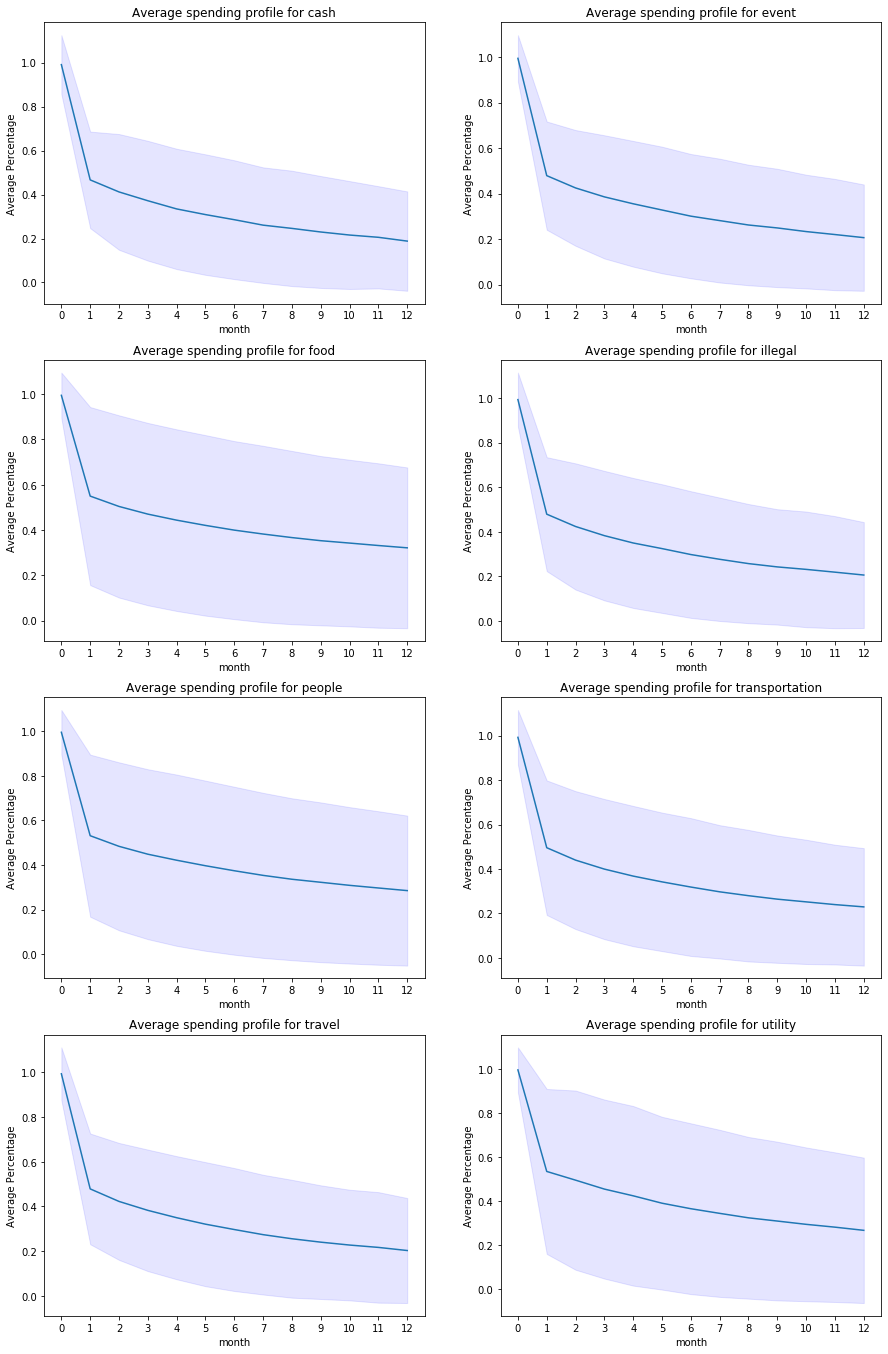

In [293]:
fig, ax = plt.subplots(figsize = (15,30))
for (i, cate) in zip(range(len(cate_list)), cate_list):
    profile_mean_std = get_mean_std(cate)
    df = profile_mean_std.toPandas()
    plt.subplot(5,2,i+1)
    plot_mean_std(df, cate)

# Social Network Analytics

## [5 pts]: Write a script to find a user’s friends and friends of friends (Friend definition: 

A user’s friend is someone who has transacted with the user, either sending money to the user or
receiving money from the user). __Describe your algorithm and calculate its computational
complexity. Can you do it better?__

In [294]:
friend_to = transaction.orderBy('user1', 'user2')

In [295]:
def rename_columns(df, columns):
    '''
    This function is used to rename multiple columns in pyspark columns
    ARG:
    - df: a pysaprk dataframe
    - columns: a dict that stores {'replace_column': new_name}
    '''
    
    if isinstance(columns, dict):
        for old_name, new_name in columns.items():
            df = df.withColumnRenamed(old_name, new_name)
        return df
    else:
        raise ValueError("'columns' should be a dict, like {'old_name_1':'new_name_1', 'old_name_2':'new_name_2'}")

In [296]:
# friend_from
friend_from = transaction.select('user2', 'user1', 'transaction_type', 'datetime', 'description', 'is_business', 'story_id')\
    .orderBy('user2', 'user1')
friend_from1 = rename_columns(friend_from, {'user1': 'user3', 'user2': 'user1', 'user3': 'user2'})
friend_from2 = friend_from1.withColumn('transaction_type',
    F.when(friend_from1['transaction_type'] == 'charge', 'payment').
    otherwise('charge'))

In [297]:
# friend_all unions friend_to and friend_from, which allows every transaction to appear twice in the dataframe
# With both users appear at 'user1' column 
friend_all = friend_to.union(friend_from2)

Keep only user_id in the friend_user dataframes for computation convenience

In [298]:
friend_user = friend_all.select('user1', 'user2').orderBy('user1', 'user2')
friend_user1 = friend_user.alias('friend_user1')
friend_user2 = friend_user.alias('friend_user2')
friend_user2 = rename_columns(friend_user2, {'user2': 'friend_of_user2'})

We considered using _cond = [f.col("friend_user1.user2") == f.col("friend_user2.user1"), f.col("friend_user1.user1") != f.col("friend_of_user2")]_ to specify that the friend's friends do not contain the user him/herself. However, excluding the user in the friend's friends list won't bring huge effects to the result, and would complicate the algorithm much more, and the effect. So we dicided to keep the original user.

In [299]:
# add constraints to join the friends' friends to the table containing user id and his/her friends

cond = [F.col("friend_user1.user2") == F.col("friend_user2.user1")]
friend_friend = friend_user1.join(friend_user2, cond, "inner")\
    .drop(F.col("friend_user2.user1"))
friend_friend = friend_friend.orderBy('friend_user1.user1', 'user2', 'friend_of_user2')

In [300]:
friend_friend_clean = friend_friend.dropDuplicates()

In [302]:
friend_friend_clean.show(10)

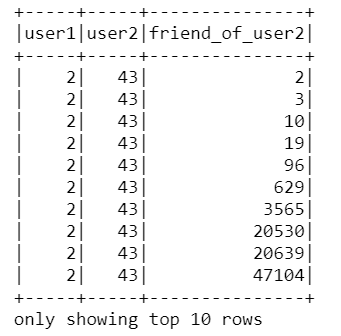

In [303]:
def find_user_friend(user_id):
    return friend_all.filter(friend_friend.user1 == user_id).dropDuplicates().select('user1', 'user2')

In [304]:
find_user_friend(2).show()

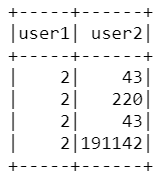

In [305]:
def find_user_friend_and_fof(user_id):
    return friend_friend_clean.filter(friend_friend.user1 == user_id).select('user1', 'user2', 'friend_of_user2')

In [306]:
find_user_friend_and_fof(2).show()

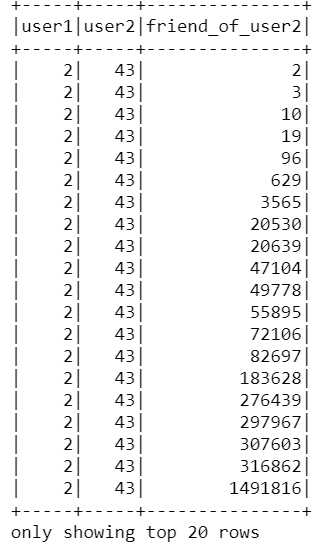

### Number of friends and number of friends of friends

In [307]:
# Calculate the number of days passed wince the user's first transaction
assign_month = F.udf(lambda x: 0 if (x == 0) else math.ceil(x/30))

In [308]:
# assign the 'month' to user1 and user2

window_user1 = Window.partitionBy('user1')
friend_all_daysPassed = friend_all.withColumn("daysPassed", F.datediff("datetime", F.min("datetime").over(window_user1)))
category_with_user1month = friend_all_daysPassed.withColumn('month', assign_month(F.col('daysPassed')))
category_with_user1month = category_with_user1month.withColumn("month", category_with_user1month["month"].cast(IntegerType()))

window_user2 = Window.partitionBy('user2')
category_with_user2month = category_with_user1month.withColumn("daysPassed2", F.datediff("datetime", F.min("datetime").over(window_user2)))
category_with_month = category_with_user2month.withColumn('month2', assign_month(F.col('daysPassed2')))
category_with_month = category_with_month.withColumn("month2", category_with_month["month2"].cast(IntegerType()))

category_with_month.createOrReplaceTempView("category_with_month")

Calculate the number of friends

In [309]:
friend_num = spark.sql("""SELECT user1, month, COUNT(DISTINCT user2) AS FRIEND_NUM
                        FROM category_with_month t1 
                        WHERE month <= 12
                        GROUP BY user1, month
                        ORDER BY user1, month""")
friend_num.createOrReplaceTempView("friend_num")

Calculate the number of friends' friends

In [310]:
# attach the number of friends' of user2 to the huge transaction table

category_with_month_wfof = spark.sql("""SELECT t1.*, t2.friend_num
                        FROM category_with_month t1
                            INNER JOIN friend_num t2 
                                ON t1.user2 = t2.user1
                                AND t1.month2 = t2.month
                        ORDER BY user1, user2""")
category_with_month_wfof.createOrReplaceTempView("category_with_month_wfof")

In [311]:
# With user1 and month1 specified, Select only distinct user2 (user1's friends) 

fof_num_tmp = spark.sql("""SELECT DISTINCT user1, month, user2, friend_num
                            FROM category_with_month_wfof
                            WHERE month <= 12
                            ORDER BY user1, month""")
fof_num_tmp.createOrReplaceTempView("fof_num_tmp")

In [312]:
# join the result

fof_num = spark.sql("""SELECT t1.user1, t1.month, IFNULL(SUM(t2.friend_num), 0) AS fof_num
                        FROM friend_num t1
                            LEFT JOIN fof_num_tmp t2
                            ON t1.user1 = t2.user1
                            AND t1.month = t2.month
                        WHERE t1.month <= 12
                        GROUP BY t1.user1, t1.month
                        ORDER BY t1.user1, t1.month""")
fof_num.createOrReplaceTempView("fof_num")

Combine the number of friends and friends' friends

In [313]:
user_f_fof_num = spark.sql("""SELECT t1.user1, t1.month, t1.friend_num, t2.fof_num
                        FROM friend_num t1 
                            LEFT JOIN fof_num t2
                            ON t1.user1 = t2.user1
                            AND t1.month = t2.month
                        WHERE t1.month <= 12
                        ORDER BY t1.user1, t1.month""")
user_f_fof_num.createOrReplaceTempView("user_f_fof_num")

In [314]:
# store the results to parquet form
user_f_fof_num.write.parquet('user_f_fof_num.parquet')

### Clustering coefficient of a user's network.

In [315]:
# Calculate possible triplets

possible_tri = spark.sql("""
                        SELECT t1.user1, t1.month, 
                            CASE 
                                WHEN t1.friend_num <= 1 THEN 0 
                                ELSE INT(t1.friend_num * (t1.friend_num -1)/2)
                                END AS possible_tri 
                        FROM friend_num t1
                        WHERE t1.month <= 12
                        ORDER BY t1.user1, t1.month""")
possible_tri.createOrReplaceTempView("possible_tri")

In [316]:
# Calculate existed triplets

existed_tri = spark.sql("""
                        SELECT t1.user1, t1.month, IFNULL(COUNT(DISTINCT *), 0) AS existed_tri
                        FROM category_with_month t1
                            INNER JOIN category_with_month t2
                                ON t1.month <= 12
                                AND t1.user2 = t2.user1
                            LEFT JOIN (SELECT DISTINCT t02.user1, t02.month, t02.user2
                                        FROM category_with_month t02
                                        WHERE t02.month <= 12
                                        ) t02
                                ON t02.user2 = t2.user2
                                AND t02.user1 = t1.user1
                                AND t02.month = t1.month
                        GROUP BY t1.user1, t1.month
                        ORDER BY t1.user1, t1.month""")
existed_tri.createOrReplaceTempView("existed_tri")

In [317]:
# Calculate clustering coefficients

cluster_coef = spark.sql("""
                        SELECT t1.user1, t1.month, IFNULL(existed_tri/possible_tri, 0) AS exicluster_coef
                        FROM possible_tri t2
                            LEFT JOIN existed_tri t1
                            ON t1.user1 = t2.user1
                            AND t1.month = t2.month
                        ORDER BY t1.user1, t1.month""")
cluster_coef.createOrReplaceTempView("cluster_coef")

In [318]:
cluster_coef.show(5)

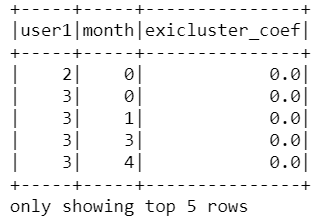

Save the results from network analytics

In [319]:
network_analytic = spark.sql("""
                        SELECT t1.*, IFNULL(t2.exicluster_coef, 0)AS cluster_coef
                        FROM user_f_fof_num t1
                            LEFT JOIN cluster_coef t2
                            ON t1.user1 = t2.user1
                            AND t1.month = t2.month
                        ORDER BY t1.user1, t1.month""")
network_analytic.createOrReplaceTempView("network_analytic")

In [320]:
network_analytic.write.parquet('network_analytic.parquet')

### Calculate the page rank of each user

_It's a dumb way to calculate the page rank, and probably would take forever to generate the results. But before I think of something smart, I'll leave them here._

In [321]:
category_with_month_lt12_payment = category_with_month.filter(category_with_month.month <= 12).select('user1', 'month', 'user2', 'month2', 'transaction_type').orderBy('user1', 'month')
category_with_month_lt12_payment = category_with_month_lt12_payment.filter(category_with_month_lt12_payment.transaction_type == 'payment')

In [322]:
user_month = category_with_month_lt12_payment.select\
                    (F.concat(F.col("user1"), F.lit("_"), F.col("month")),\
                     F.concat(F.col("user2"), F.lit("_"), F.col("month2")),\
                     category_with_month_lt12_payment.transaction_type)
user_month = user_month.withColumnRenamed('concat(user1, _, month)', 'user1_month')
user_month = user_month.withColumnRenamed('concat(user2, _, month2)', 'user2_month')

In [323]:
user_month_edge = user_month.withColumnRenamed('user1_month', 'src')
user_month_edge = user_month_edge.withColumnRenamed('user2_month', 'dst')
user_month_edge = user_month_edge.withColumnRenamed('transaction_type', 'relationship')

In [324]:
verticesDf = user_month.select('user1_month').union(user_month.select('user2_month'))
verticesDf = verticesDf.withColumnRenamed('user1_month', 'id')

In [325]:
g = GraphFrame(verticesDf, user_month_edge)
pr = g.pageRank(resetProbability=0.15, tol=0.01)

## Predictive Analysis with MLlib

### Q7. Compute total number of transactions within 12 months for each user

In [31]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [32]:
# create table containing 'user' and the number of transactions within 12 months
transaction.createOrReplaceTempView("transaction2")
df1 = spark.sql("select user1 as user, datetime from transaction2 union all select user2 as user, datetime from transaction2")

df1.createOrReplaceTempView("df1")
df2 = spark.sql("select user, datetime, min(datetime) over (partition by user order by user, datetime) as first_time_transaction from df1")

df2.createOrReplaceTempView("df2")
df3 = spark.sql("select user, date_format(first_time_transaction,'Y/M/d') as first_time_transaction,date_format(datetime,'Y/M/d') as datetime from df2")

df3.createOrReplaceTempView("df3")
df4 = spark.sql("select * from (select user, months_between(datetime, first_time_transaction) as months_after_first_transaction from df2) t where t.months_after_first_transaction < 12")

df4.createOrReplaceTempView("df4")
df5 = spark.sql("select user, count(*) as number_of_transactions_within_12_months from df4 group by user")

df5.createOrReplaceTempView("df5")

In [93]:
df5.show(5)

+----+---------------------------------------+
|user|number_of_transactions_within_12_months|
+----+---------------------------------------+
|2866|                                      1|
|3918|                                      2|
|4935|                                      1|
|5300|                                      4|
|6620|                                      1|
+----+---------------------------------------+
only showing top 5 rows



### Q8. Create the Recency and Frequency variables

In [344]:
from pyspark.sql.window import Window
import pyspark.sql.functions as F
import math

window = Window.partitionBy('User')

trans_with_daysPassed = df1.withColumn("daysPassed", F.datediff("dateTime", F.min("dateTime").over(window)))

assign_month = F.udf(lambda x: 0 if (x == 0) else math.ceil(x/30))

category_with_month = trans_with_daysPassed.withColumn('month', assign_month(F.col('daysPassed')))
category_with_month = category_with_month.withColumn("month", category_with_month["month"].cast(IntegerType()))

In [345]:
category_with_month.createOrReplaceTempView("category_with_month")
cate_month_12 = spark.sql("""SELECT * FROM category_with_month WHERE month <= 12""")
cate_month_12.createOrReplaceTempView("cate_month_12")

In [346]:
cate_month_12.show(10)

+-----+-------------------+----------+-----+
| user|           datetime|daysPassed|month|
+-----+-------------------+----------+-----+
| 2866|2015-09-15 14:27:00|         0|    0|
| 3918|2016-03-13 18:57:15|         0|    0|
| 3918|2016-03-14 01:25:42|         1|    1|
| 4935|2014-04-14 00:57:19|         0|    0|
| 5300|2016-04-07 17:30:43|       112|    4|
| 5300|2015-12-17 02:05:27|         0|    0|
| 5300|2016-06-05 14:40:07|       171|    6|
| 5300|2016-06-09 00:34:17|       175|    6|
| 6620|2012-04-16 14:32:43|         0|    0|
|20735|2014-06-17 14:54:30|         0|    0|
+-----+-------------------+----------+-----+
only showing top 10 rows



In [348]:
# create lifetime table for all users containing t0 - t11
lst = [0,1,2,3,4,5,6,7,8,9,10,11,12]
df_time = df5.withColumn("time_lst", F.array([F.lit(x) for x in lst]))
df_time = df_time.withColumn("time_lst", F.explode(col("time_lst")))

In [349]:
df_sum = spark.sql("select user, month as lifetime_indicator, count(*) as freq_times, \
                              max(daysPassed) as max_days \
                        from cate_month_12 \
                        group by user, month")

df_time.createOrReplaceTempView("df_time")
df_sum.createOrReplaceTempView("df_sum")

In [350]:
df_sum.show()

+------+------------------+----------+--------+
|  user|lifetime_indicator|freq_times|max_days|
+------+------------------+----------+--------+
| 59990|                 0|         1|       0|
|124967|                 0|         1|       0|
|171142|                 9|         1|     252|
|178199|                 8|         1|     221|
|187647|                 5|         1|     136|
|196615|                 0|         1|       0|
|215820|                 9|         3|     249|
|216006|                 0|         1|       0|
|243018|                 5|         1|     143|
|260195|                 0|         1|       0|
|275481|                 1|         1|       9|
|281718|                10|         1|     282|
|296738|                 2|         1|      39|
|307982|                 0|         1|       0|
|308930|                 1|         2|      13|
|320508|                 0|         1|       0|
|326538|                 0|         1|       0|
|350569|                 9|         1|  

In [351]:
df_time.show()

+----+---------------------------------------+--------+
|user|number_of_transactions_within_12_months|time_lst|
+----+---------------------------------------+--------+
|2866|                                      1|       0|
|2866|                                      1|       1|
|2866|                                      1|       2|
|2866|                                      1|       3|
|2866|                                      1|       4|
|2866|                                      1|       5|
|2866|                                      1|       6|
|2866|                                      1|       7|
|2866|                                      1|       8|
|2866|                                      1|       9|
|2866|                                      1|      10|
|2866|                                      1|      11|
|2866|                                      1|      12|
|3918|                                      2|       0|
|3918|                                      2|  

In [191]:
df_sum2 = spark.sql("select user, lifetime_indicator, max(max_days) as max_days, \
                        max(freq_times) as freq_times \
                  from \
                      (select user, lifetime_indicator, max_days, freq_times from df_sum \
                      union  \
                      select user, time_lst, null as max_days, null as freq_times \
                      from df_time) T \
                  group by user, lifetime_indicator \
                  order by user, lifetime_indicator ")

df_sum2.createOrReplaceTempView("df_sum2")
df_sum2.show()

+----+------------------+--------+----------+
|user|lifetime_indicator|max_days|freq_times|
+----+------------------+--------+----------+
|   2|                 0|       0|         1|
|   2|                 1|    null|      null|
|   2|                 2|    null|      null|
|   2|                 3|    null|      null|
|   2|                 4|    null|      null|
|   2|                 5|    null|      null|
|   2|                 6|    null|      null|
|   2|                 7|    null|      null|
|   2|                 8|    null|      null|
|   2|                 9|    null|      null|
|   2|                10|    null|      null|
|   2|                11|    null|      null|
|   3|                 0|       0|         1|
|   3|                 1|      26|         1|
|   3|                 2|    null|      null|
|   3|                 3|      88|         1|
|   3|                 4|     104|         5|
|   3|                 5|     125|         1|
|   3|                 6|    null|

In [352]:
# create the final table with recency, frequency, lifetime 
RF = spark.sql("select user, lifetime_indicator, max_days, \
                ifnull(freq_times, 0)/30 as frequency, \
                (lifetime_indicator*30-max(max_days) \
                    over(partition by user \
                         order by lifetime_indicator asc \
                         range between unbounded preceding and current row)) as recency \
              from df_sum2 \
              order by user, lifetime_indicator")

RF.createOrReplaceTempView("df_x")
RF.show(60)

AnalysisException: 'Table or view not found: df_sum2; line 1 pos 358'

### Q9. Regress recency and frequency on Y and plot the MSE for each lifetime plot

In [42]:
from pyspark.ml.regression import LinearRegression

In [333]:
# # join two tables into one table containing frequency, recency, lifetime and number of transactions
df5.createOrReplaceTempView("df5")
RF_final = spark.sql("select RF.user, RF.lifetime_indicator as lifetime, RF.frequency as frequency_within_month, RF.recency as recency_within_month, df5.number_of_transactions_within_12_months from RF inner join df5 on RF.user = df5.user")

In [215]:
RF_final.createOrReplaceTempView("RF_final_2")

t0 = spark.sql("select * from RF_final_2 where lifetime = 0")
t1 = spark.sql("select * from RF_final_2 where lifetime = 1")
t2 = spark.sql("select * from RF_final_2 where lifetime = 2")
t3 = spark.sql("select * from RF_final_2 where lifetime = 3")
t4 = spark.sql("select * from RF_final_2 where lifetime = 4")
t5 = spark.sql("select * from RF_final_2 where lifetime = 5")
t6 = spark.sql("select * from RF_final_2 where lifetime = 6")
t7 = spark.sql("select * from RF_final_2 where lifetime = 7")
t8 = spark.sql("select * from RF_final_2 where lifetime = 8")
t9 = spark.sql("select * from RF_final_2 where lifetime = 9")
t10 = spark.sql("select * from RF_final_2 where lifetime = 10")
t11 = spark.sql("select * from RF_final_2 where lifetime = 11")
t12 = spark.sql("select * from RF_final_2 where lifetime = 12")

In [211]:
# define the linear regression model
def linear_model(data):
    from pyspark.ml.regression import LinearRegression
    from pyspark.ml.evaluation import RegressionEvaluator
    from pyspark.ml.feature import VectorAssembler
    vectorAssembler = VectorAssembler(inputCols = ['recency_within_month', 'frequency_within_month','lifetime'], outputCol = 'features')
    transformed = vectorAssembler.transform(data)
    transformed = transformed.select('features', 'number_of_transactions_within_12_months')

    train_df, test_df = transformed.randomSplit([0.7, 0.3], seed = 1)

    lr = LinearRegression(featuresCol = 'features', labelCol='number_of_transactions_within_12_months')
    lr_model = lr.fit(train_df)

    testResults = lr_model.evaluate(test_df)
    rmse = testResults.rootMeanSquaredError
    mse = rmse**2
  
    return mse

In [212]:
mse_t0 = linear_model(t0)

In [213]:
mse_t0

11.168223910854033

In [216]:
mse_t1 = linear_model(t1)

In [217]:
mse_t1

9.590800710097822

In [218]:
mse_t2 = linear_model(t2)

In [219]:
mse_t2

8.738414171514538

In [220]:
mse_t3 = linear_model(t3)

In [221]:
mse_t3

8.016839058200496

In [222]:
mse_t4 = linear_model(t4)

In [223]:
mse_t4

7.400945275016231

In [224]:
mse_t5 = linear_model(t5)

In [225]:
mse_t5

6.906812386075373

In [226]:
mse_t6 = linear_model(t6)

In [227]:
mse_t6

6.338554273812906

In [228]:
mse_t7 = linear_model(t7)

In [229]:
mse_t7

5.907770253110363

In [230]:
mse_t8 = linear_model(t8)

In [231]:
mse_t8

5.629108673942838

In [232]:
mse_t9 = linear_model(t9)

In [233]:
mse_t9

6.358413810636061

In [234]:
mse_t10 = linear_model(t10)

In [251]:
mse_t10

5.398

In [236]:
mse_t11 = linear_model(t11)

In [252]:
mse_t11

4.987

In [335]:
mse_t12 = linear_model(t12)

In [337]:
mse_t12

4.59885

In [340]:
mse = [mse_t0, mse_t1, mse_t2, mse_t3, mse_t4, mse_t5, mse_t6, mse_t7, mse_t8, mse_t9, mse_t10,mse_t11,mse_t12]

In [243]:
import matplotlib.pyplot as plt

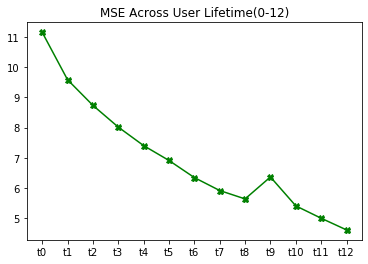

In [342]:
# plot the MSE plot
plt.plot(range(0,13), mse, marker = 'X', c = 'g')
plt.title('MSE Across User Lifetime(0-12)')
plt.xticks(range(0,13),['t0','t1','t2','t3','t4','t5','t6','t7','t8','t9','t10','t11','t12'])
plt.show()

### Q10 For each user’s lifetime point, regress recency, frequency AND her spending behavior profile on Y. Plot the MSE for each lifetime point like above. Did you get any improvement?

In [253]:
# join the Recency-Frequency table with the spending behavior profile table
combined1 = spark.sql("""select *
from dynamic_profile_clean inner join RF_final on dynamic_profile_clean.User=RF_final.user and dynamic_profile_clean.month=RF_final.lifetime""")

In [254]:
combined1.show(3)

+-------+-----+-----+-----------+---------+--------+----+-----+------------------+-------+-------------------+-------------------+------+-------+-----+--------+----------------------+--------------------+---------------------------------------+
|    _c0| User|month|total_trans|total_sum|activity|cash|event|              food|illegal|             people|     transportation|travel|utility| user|lifetime|frequency_within_month|recency_within_month|number_of_transactions_within_12_months|
+-------+-----+-----+-----------+---------+--------+----+-----+------------------+-------+-------------------+-------------------+------+-------+-----+--------+----------------------+--------------------+---------------------------------------+
|1840078|   43|    7|          1|        6|     0.0| 0.0|  0.0|0.3333333333333333|    0.0|0.16666666666666666|0.16666666666666666|   0.0|    0.0|   43|       7|   0.03333333333333333|                   6|                                     18|
|1264749| 2391|   11

In [255]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['recency_within_month', 'frequency_within_month','activity','cash','event','food','illegal','people','transportation','travel','utility'], outputCol = 'features')
combined1 = vectorAssembler.transform(combined1)
combined1 = combined1.select(['features', 'number_of_transactions_within_12_months','lifetime'])

In [256]:
combined1.createOrReplaceTempView("combined1")
t0 = spark.sql("select features, number_of_transactions_within_12_months from combined1 where lifetime = 0")
t1 = spark.sql("select features, number_of_transactions_within_12_months from combined1 where lifetime = 1")
t2 = spark.sql("select features, number_of_transactions_within_12_months from combined1 where lifetime = 2")
t3 = spark.sql("select features, number_of_transactions_within_12_months from combined1 where lifetime = 3")
t4 = spark.sql("select features, number_of_transactions_within_12_months from combined1 where lifetime = 4")
t5 = spark.sql("select features, number_of_transactions_within_12_months from combined1 where lifetime = 5")
t6 = spark.sql("select features, number_of_transactions_within_12_months from combined1 where lifetime = 6")
t7 = spark.sql("select features, number_of_transactions_within_12_months from combined1 where lifetime = 7")
t8 = spark.sql("select features, number_of_transactions_within_12_months from combined1 where lifetime = 8")
t9 = spark.sql("select features, number_of_transactions_within_12_months from combined1 where lifetime = 9")
t10 = spark.sql("select features, number_of_transactions_within_12_months from combined1 where lifetime = 10")
t11 = spark.sql("select features, number_of_transactions_within_12_months from combined1 where lifetime = 11")

In [257]:
mse_t0 = linear_model(t0)
mse_t1 = linear_model(t1)
mse_t2 = linear_model(t2)
mse_t3 = linear_model(t3)
mse_t4 = linear_model(t4)
mse_t5 = linear_model(t5)
mse_t6 = linear_model(t6)
mse_t7 = linear_model(t7)
mse_t8 = linear_model(t8)
mse_t9 = linear_model(t9)
mse_t10 = linear_model(t10)
mse_t11 = linear_model(t11)

In [258]:
mse = [mse_t0, mse_t1, mse_t2, mse_t3, mse_t4, mse_t5, mse_t6, mse_t7, mse_t8, mse_t9, mse_t10,mse_t11]

In [259]:
plt.plot(range(0,12), mse, marker = 'X', c = 'g')
plt.title('MSE Across User Lifetime(0-11)')
plt.xticks(range(0,12),['t0','t1','t2','t3','t4','t5','t6','t7','t8','t9','t10','t11'])
plt.show()

<img style="float: left;" src="Q10.png" width="40%">

### Q11 For each user’s lifetime point, regress her social network metrics on Y. Plot the MSE for each lifetime point like above. What do you observe? How do social network metrics compare with the RF framework? What are the most informative predictors?

In [265]:
# join the Recency-Frequency table with the social network metric table
combined2 = spark.sql("""select *
from network_analytic inner join RF_final on network_analytic.user1=RF_final.user and network_analytic.month=RF_final.lifetime""")

In [266]:
combined2.show(3)

In [ ]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['friend_num','fof_num','cluster_coef'], outputCol = 'features')
combined2 = vectorAssembler.transform(combined2)
combined2 = combined2.select(['features', 'number_of_transactions_within_12_months','lifetime'])
combined2.show(20)

In [ ]:
combined2.createOrReplaceTempView("combined2")
t0 = spark.sql("select features, number_of_transactions_within_12_months from combined2 where lifetime = 0")
t1 = spark.sql("select features, number_of_transactions_within_12_months from combined2 where lifetime = 1")
t2 = spark.sql("select features, number_of_transactions_within_12_months from combined2 where lifetime = 2")
t3 = spark.sql("select features, number_of_transactions_within_12_months from combined2 where lifetime = 3")
t4 = spark.sql("select features, number_of_transactions_within_12_months from combined2 where lifetime = 4")
t5 = spark.sql("select features, number_of_transactions_within_12_months from combined2 where lifetime = 5")
t6 = spark.sql("select features, number_of_transactions_within_12_months from combined2 where lifetime = 6")
t7 = spark.sql("select features, number_of_transactions_within_12_months from combined2 where lifetime = 7")
t8 = spark.sql("select features, number_of_transactions_within_12_months from combined2 where lifetime = 8")
t9 = spark.sql("select features, number_of_transactions_within_12_months from combined2 where lifetime = 9")
t10 = spark.sql("select features, number_of_transactions_within_12_months from combined2 where lifetime = 10")
t11 = spark.sql("select features, number_of_transactions_within_12_months from combined2 where lifetime = 11")

In [ ]:
mse = []

for model in [t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11]:
    mse.append(linear_model(model))

In [ ]:
plt.plot(range(0,12), mse, marker = 'X', c = 'g')
plt.title('MSE Across User Lifetime(0-11)')
plt.xticks(range(0,12),['t0','t1','t2','t3','t4','t5','t6','t7','t8','t9','t10','t11'])
plt.show()

### Q12 For each user’s lifetime point, regress her social network metrics and the spending behavior of her social network on Y. Plot the MSE for each lifetime point like above. Does the spending behavior of her social network add any predictive benefit compared to Q10?

In [ ]:
#calcualte dynamic social network spending behavior

combined3 = spark.sql("""select user1, netbehave_dynamic.month,mean(number_of_transactions_within_12_months) number_of_transactions_within_12_months, mean(friend_num) friend_num, mean(fof_num) fof_num, mean(cluster_coef) cluster_coef, avg(activity) activity, avg(cash) cash, avg(event) event, avg(food) food, avg(illegal) as illegal,
avg(people) people, avg(transportation) transportation, avg(travel) travel, avg(utility) utility
from netbehave_dynamic inner join dynamic_profile_clean on netbehave_dynamic.user2=dynamic_profile_clean.User and netbehave_dynamic.month=dynamic_profile_clean.month
group by netbehave_dynamic.month and netbehave_dynamic.user1""")


In [ ]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['friend_num','fof_num','cluster_coef','activity','cash','event','food','illegal','people','transportation','travel','utility'], outputCol = 'features')
combined3 = vectorAssembler.transform(combined3)
combined3 = combined2.select(['features', 'number_of_transactions_within_12_months','month'])


In [ ]:
combined3.createOrReplaceTempView("combined3")
t0 = spark.sql("select features, number_of_transactions_within_12_months from combined3 where month = 0")
t1 = spark.sql("select features, number_of_transactions_within_12_months from combined3 where month = 1")
t2 = spark.sql("select features, number_of_transactions_within_12_months from combined3 where month = 2")
t3 = spark.sql("select features, number_of_transactions_within_12_months from combined3 where month = 3")
t4 = spark.sql("select features, number_of_transactions_within_12_months from combined3 where month = 4")
t5 = spark.sql("select features, number_of_transactions_within_12_months from combined3 where month = 5")
t6 = spark.sql("select features, number_of_transactions_within_12_months from combined3 where month = 6")
t7 = spark.sql("select features, number_of_transactions_within_12_months from combined3 where month = 7")
t8 = spark.sql("select features, number_of_transactions_within_12_months from combined3 where month = 8")
t9 = spark.sql("select features, number_of_transactions_within_12_months from combined3 where month = 9")
t10 = spark.sql("select features, number_of_transactions_within_12_months from combined3 where month = 10")
t11 = spark.sql("select features, number_of_transactions_within_12_months from combined3 where month = 11")

In [ ]:
mse = []

for model in [t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11]:
    mse.append(linear_model(model))
    
plt.plot(range(0,12), mse, marker = 'X', c = 'g')
plt.title('MSE Across User Lifetime(0-11)')
plt.xticks(range(0,12),['t0','t1','t2','t3','t4','t5','t6','t7','t8','t9','t10','t11'])
plt.show()